In [3]:
import pandas as pd
import re
import spacy

# 1. Load data
df = pd.read_csv("data/reddit data.csv")

df.isnull().sum()

id                 0
created_utc        0
subreddit          0
listing            0
title              0
selftext        2658
url                0
num_comments       0
comments        8449
dtype: int64

In [2]:
import pandas as pd
import re

# 1. Load Reddit data
df = pd.read_csv('data/reddit data.csv')

# 2. Combine title and selftext for richer context
df['raw_text'] = df['title'].fillna('') + ' ' + df['selftext'].fillna('')

# 3. Define cleaning function
def clean_text(text):
    if pd.isna(text):
        return ""
    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", "", text)
    # Remove user-mentions and subreddit tags
    text = re.sub(r"@\w+|/r/\w+", "", text)
    # Remove Markdown links and HTML tags
    text = re.sub(r"<.*?>|\[.*?\]\(.*?\)", "", text)
    # Remove all punctuation except apostrophes
    text = re.sub(r"[^\w\s']", " ", text)
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text)
    # Lowercase
    return text.strip().lower()

# 4. Apply cleaning function
df['clean_text'] = df['raw_text'].apply(clean_text)

# 5. Drop rows with empty cleaned text
df = df[df['clean_text'].str.strip().astype(bool)].reset_index(drop=True)

# 6. Drop duplicates 
# A. By unique Reddit ID 
df = df.drop_duplicates(subset=['id'])


# 7. Save cleaned data with new filename
df.to_csv('reddit_clean_data.csv', index=False)
print(f"Saved cleaned data ({len(df)} posts) to reddit_clean_data.csv")



Saved cleaned data (43122 posts) to reddit_clean_data.csv


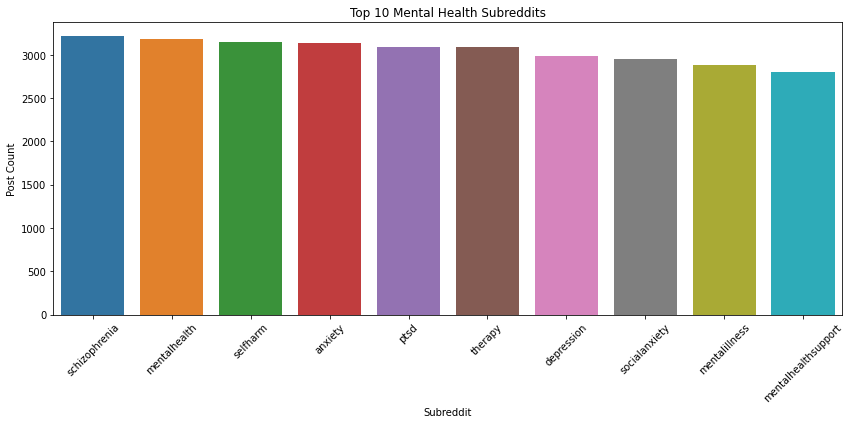

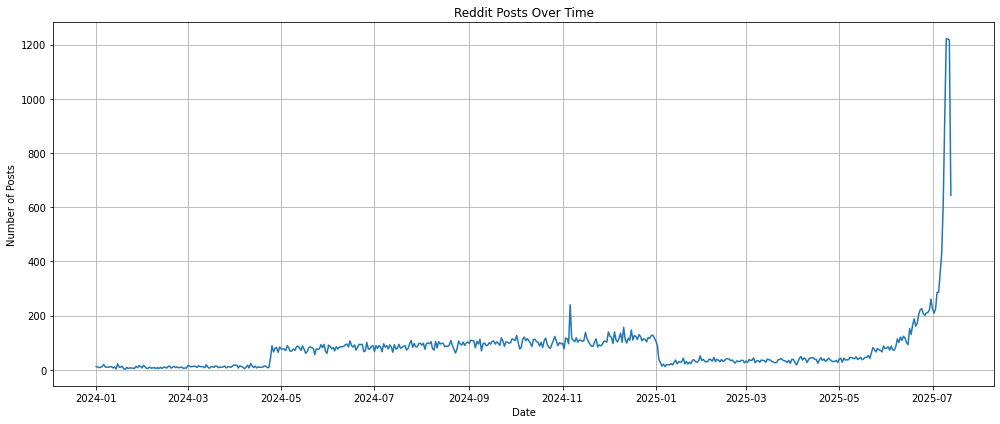

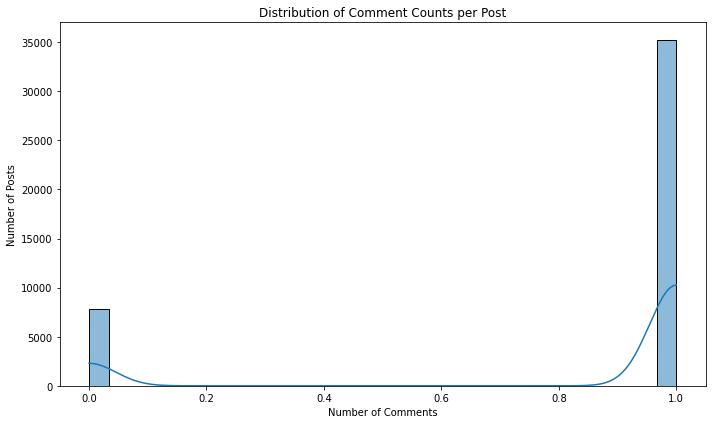

Reddit Data Summary:
                label          created_utc  comment_count
count           43122                43122   43122.000000
unique             17                43058            NaN
top     schizophrenia  2024-10-30 13:18:59            NaN
freq             3213                    5            NaN
first             NaN  2024-01-01 00:19:44            NaN
last              NaN  2025-07-13 18:00:09            NaN
mean              NaN                  NaN       0.817448
std               NaN                  NaN       0.386303
min               NaN                  NaN       0.000000
25%               NaN                  NaN       1.000000
50%               NaN                  NaN       1.000000
75%               NaN                  NaN       1.000000
max               NaN                  NaN       1.000000


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_95464/2707623437.py:55: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  summary_stats = reddit_df[['label', 'created_utc', 'comment_count']].describe(include='all')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load only the Reddit dataset
reddit_df = pd.read_csv("reddit_clean_data.csv")

# Add platform and label 
reddit_df['platform'] = 'Reddit'
reddit_df['label'] = reddit_df['subreddit'].str.lower()

# Convert timestamp to datetime
reddit_df['created_utc'] = pd.to_datetime(reddit_df['created_utc'], errors='coerce')

# Posts over time
posts_by_date = reddit_df.groupby(reddit_df['created_utc'].dt.date).size()

# Top subreddits (labels)
top_labels = reddit_df['label'].value_counts().head(10)

# Comment length distribution
reddit_df['comment_count'] = reddit_df['comments'].apply(lambda x: len(str(x).split('\n')) if pd.notnull(x) else 0)

# Plot 1: Top subreddits
plt.figure(figsize=(12, 6))
sns.barplot(x=top_labels.index, y=top_labels.values)
plt.title("Top 10 Mental Health Subreddits")
plt.xlabel("Subreddit")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Posts over time
plt.figure(figsize=(14, 6))
posts_by_date.plot()
plt.title("Reddit Posts Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Comment depth
plt.figure(figsize=(10, 6))
sns.histplot(reddit_df['comment_count'], bins=30, kde=True)
plt.title("Distribution of Comment Counts per Post")
plt.xlabel("Number of Comments")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

# Display basic insights in tabular form

summary_stats = reddit_df[['label', 'created_utc', 'comment_count']].describe(include='all')
print("Reddit Data Summary:")
print("=" * 50)
print(summary_stats)


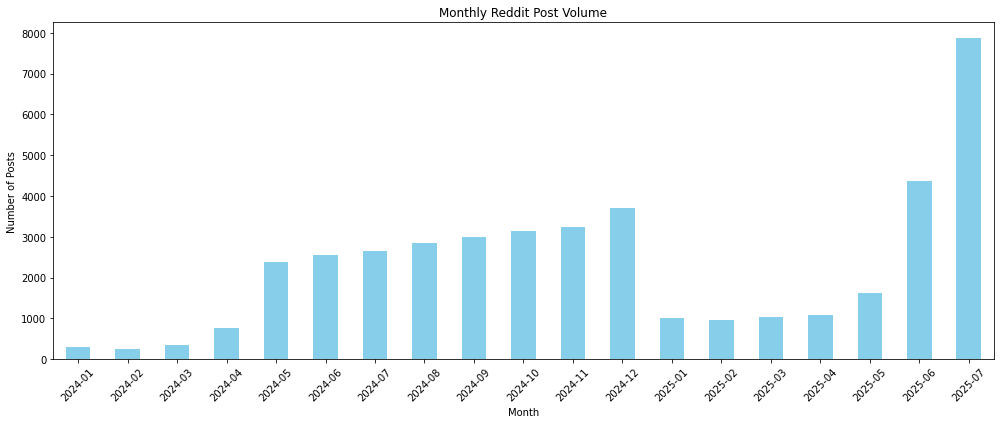

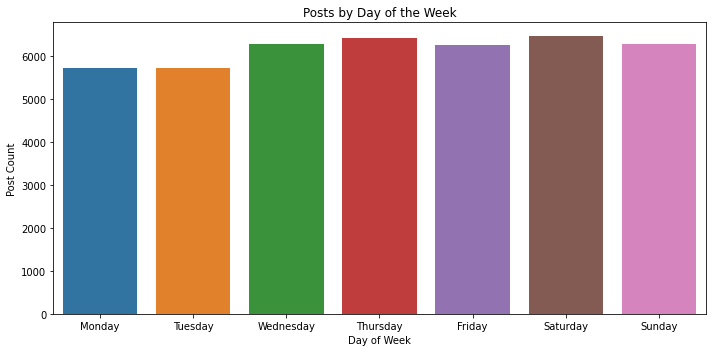

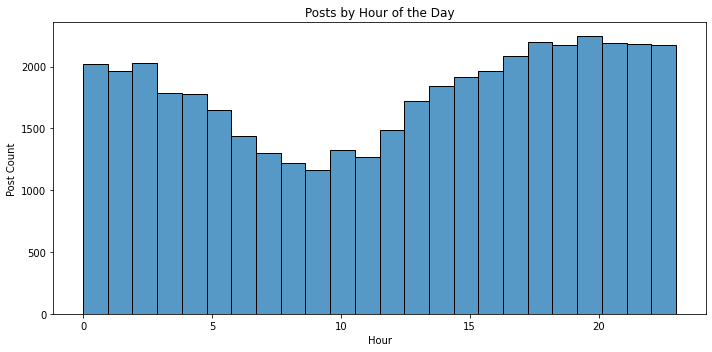

<Figure size 1008x432 with 0 Axes>

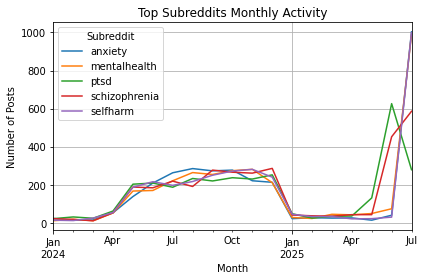

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Reddit data
reddit_df = pd.read_csv("reddit_clean_data.csv")

# Parse datetime
reddit_df['created_utc'] = pd.to_datetime(reddit_df['created_utc'], errors='coerce')
reddit_df['label'] = reddit_df['subreddit'].str.lower()

# Extract temporal features
reddit_df['year'] = reddit_df['created_utc'].dt.year
reddit_df['month'] = reddit_df['created_utc'].dt.month
reddit_df['day_of_week'] = reddit_df['created_utc'].dt.day_name()
reddit_df['hour'] = reddit_df['created_utc'].dt.hour

# --- 1. Posts per Month-Year ---
monthly_posts = reddit_df.groupby([reddit_df['created_utc'].dt.to_period('M')]).size()

plt.figure(figsize=(14, 6))
monthly_posts.plot(kind='bar', color='skyblue')
plt.title("Monthly Reddit Post Volume")
plt.xlabel("Month")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 2. Posts by Day of Week ---
plt.figure(figsize=(10, 5))
sns.countplot(data=reddit_df, x='day_of_week', order=[
              'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Posts by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Post Count")
plt.tight_layout()
plt.show()

# --- 3. Posts by Hour of Day ---
plt.figure(figsize=(10, 5))
sns.histplot(reddit_df['hour'], bins=24, kde=False)
plt.title("Posts by Hour of the Day")
plt.xlabel("Hour")
plt.ylabel("Post Count")
plt.tight_layout()
plt.show()

# --- 4. Subreddit Activity Over Time (Top 5 Subreddits) ---
top_labels = reddit_df['label'].value_counts().head(5).index.tolist()
filtered = reddit_df[reddit_df['label'].isin(top_labels)]
label_monthly = filtered.groupby([filtered['created_utc'].dt.to_period('M'), 'label']).size().unstack().fillna(0)

plt.figure(figsize=(14, 6))
label_monthly.plot()
plt.title("Top Subreddits Monthly Activity")
plt.xlabel("Month")
plt.ylabel("Number of Posts")
plt.legend(title="Subreddit")
plt.tight_layout()
plt.grid(True)
plt.show()


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_747/1122022924.py:8: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("reddit_clean_data.csv")


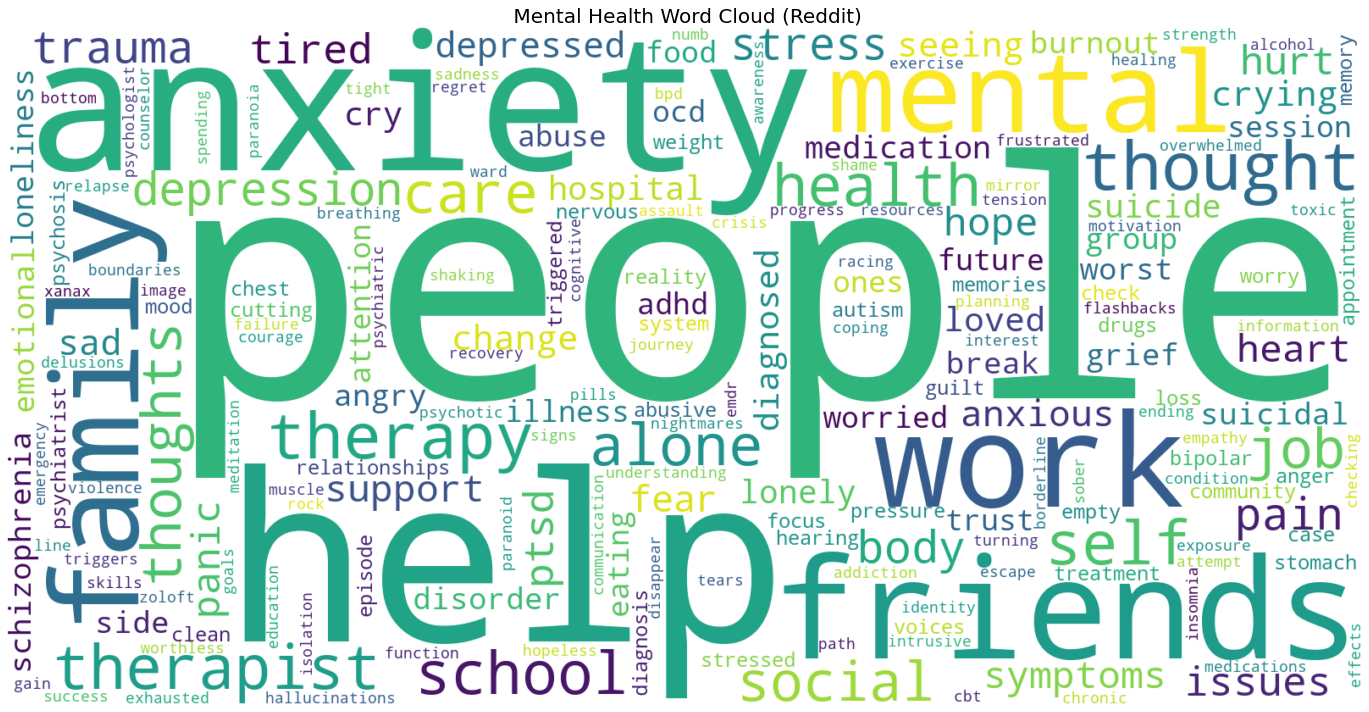

In [ ]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import re

# Load data
df = pd.read_csv("reddit_clean_data.csv")
text_data = df['clean_text'].dropna().astype(str).str.lower().tolist()
joined_text = ' '.join(text_data)

# Clean punctuation
joined_text = re.sub(r'[^a-zA-Z\s]', '', joined_text)

# Extended mental health vocabulary
mental_health_vocab = {
    # Core mental health terms
    'anxiety', 'anxious', 'panic', 'fear', 'worry', 'worried', 'overwhelmed', 'nervous', 'restless',
    'depression', 'depressed', 'sad', 'sadness', 'hopeless', 'hopelessness', 'despair', 'melancholy',
    'stress', 'stressed', 'burnout', 'exhausted', 'tired', 'fatigue', 'drained', 'overwhelmed',
    
    # Emotional states
    'lonely', 'loneliness', 'isolation', 'alone', 'empty', 'numbness', 'numb', 'worthless', 
    'shame', 'guilt', 'regret', 'anger', 'angry', 'frustrated', 'irritated', 'agitated',
    'crying', 'cry', 'tears', 'grief', 'mourning', 'loss', 'heartbroken', 'devastated',
    
    # Sleep and energy
    'insomnia', 'sleepless', 'nightmares', 'sleepy', 'drowsy', 'restless', 'tossing', 'turning',
    'oversleeping', 'hypersomnia', 'zombie', 'sluggish', 'lethargic', 'weary', 'worn',
    
    # Suicidal ideation and self-harm
    'suicidal', 'suicide', 'selfharm', 'cutting', 'hurt', 'pain', 'ending', 'escape', 'disappear',
    'ideation', 'thoughts', 'planning', 'attempt', 'crisis', 'emergency', 'hotline',
    
    # Trauma and PTSD
    'trauma', 'ptsd', 'flashbacks', 'triggers', 'triggered', 'abuse', 'violence', 'assault',
    'memories', 'intrusive', 'avoidance', 'hypervigilant', 'dissociation', 'detachment',
    'survivor', 'recovery', 'healing', 'coping', 'resilience',
    
    # Anxiety disorders
    'phobia', 'agoraphobia', 'claustrophobia', 'social', 'generalized', 'gad', 'panic',
    'palpitations', 'sweating', 'trembling', 'shaking', 'breathless', 'choking',
    'racing', 'catastrophic', 'catastrophizing', 'worst', 'case', 'scenario',
    
    # Depression symptoms
    'anhedonia', 'pleasure', 'interest', 'motivation', 'concentration', 'focus',
    'memory', 'indecisive', 'sluggish', 'psychomotor', 'agitation', 'retardation',
    'appetite', 'weight', 'gain', 'loss', 'eating', 'food',
    
    # Mood disorders
    'bipolar', 'manic', 'mania', 'hypomania', 'episode', 'cycling', 'mood', 'swings',
    'euphoric', 'grandiose', 'impulsive', 'reckless', 'spending', 'hypersexual',
    'dysthymia', 'persistent', 'chronic', 'seasonal', 'affective',
    
    # Personality disorders
    'borderline', 'bpd', 'splitting', 'abandonment', 'unstable', 'identity', 'relationships',
    'narcissistic', 'npd', 'grandiosity', 'empathy', 'antisocial', 'sociopath', 'psychopath',
    'avoidant', 'dependent', 'paranoid', 'schizoid', 'histrionic', 'obsessive', 'compulsive',
    
    # Psychosis and severe mental illness
    'psychosis', 'psychotic', 'hallucinations', 'voices', 'hearing', 'seeing', 'delusions',
    'paranoia', 'paranoid', 'conspiracy', 'persecution', 'reality', 'testing', 'break',
    'schizophrenia', 'schizoaffective', 'catatonia', 'disorganized', 'thought', 'disorder',
    
    # Eating disorders
    'anorexia', 'bulimia', 'binge', 'purge', 'restrict', 'restriction', 'calories',
    'weight', 'body', 'image', 'dysmorphia', 'orthorexia', 'emotional', 'compulsive',
    'laxatives', 'vomiting', 'exercise', 'excessive', 'mirror', 'checking',
    
    # OCD and related disorders
    'ocd', 'obsessions', 'compulsions', 'intrusive', 'unwanted', 'repetitive', 'rituals',
    'checking', 'washing', 'counting', 'ordering', 'symmetry', 'contamination',
    'hoarding', 'trichotillomania', 'dermatillomania', 'picking', 'pulling',
    
    # Addiction and substance use
    'addiction', 'substance', 'alcohol', 'drugs', 'withdrawal', 'detox', 'rehab',
    'relapse', 'recovery', 'sobriety', 'clean', 'sober', 'cravings', 'triggers',
    'enabling', 'codependent', 'rock', 'bottom', 'intervention', 'aa', 'na',
    
    # ADHD and neurodevelopmental
    'adhd', 'attention', 'hyperactive', 'impulsive', 'focus', 'concentration', 'distracted',
    'procrastination', 'executive', 'function', 'autism', 'aspergers', 'sensory',
    'stimming', 'meltdown', 'shutdown', 'masking', 'social', 'communication',
    
    # Treatment and therapy
    'therapy', 'therapist', 'counseling', 'counselor', 'psychologist', 'psychiatrist',
    'psychotherapy', 'cbt', 'dbt', 'emdr', 'exposure', 'mindfulness', 'meditation',
    'session', 'appointment', 'treatment', 'intervention', 'support', 'group',
    'individual', 'family', 'couples', 'behavioral', 'cognitive', 'dialectical',
    
    # Medications
    'medication', 'medications', 'pills', 'prescription', 'antidepressant', 'ssri', 'snri',
    'antipsychotic', 'mood', 'stabilizer', 'lithium', 'benzodiazepine', 'xanax', 'ativan',
    'prozac', 'zoloft', 'lexapro', 'wellbutrin', 'abilify', 'seroquel', 'lamictal',
    'side', 'effects', 'withdrawal', 'titration', 'dosage', 'increase', 'decrease',
    
    # Crisis and hospitalization
    'crisis', 'emergency', 'hospital', 'psychiatric', 'ward', 'inpatient', 'outpatient',
    'admission', 'discharge', 'evaluation', 'assessment', 'screening', 'triage',
    '911', 'hotline', 'crisis', 'line', 'intervention', 'welfare', 'check',
    
    # Coping and support
    'coping', 'strategies', 'mechanisms', 'skills', 'techniques', 'grounding', 'breathing',
    'relaxation', 'progressive', 'muscle', 'visualization', 'journaling', 'exercise',
    'support', 'system', 'friends', 'family', 'loved', 'ones', 'community', 'peer',
    'understanding', 'empathy', 'compassion', 'validation', 'acceptance', 'hope',
    
    # Mental health awareness
    'mental', 'health', 'illness', 'disorder', 'condition', 'diagnosis', 'diagnosed',
    'symptoms', 'signs', 'awareness', 'stigma', 'discrimination', 'understanding',
    'education', 'advocacy', 'campaign', 'resources', 'information', 'help',
    
    # Physical symptoms
    'headaches', 'migraines', 'tension', 'muscle', 'aches', 'pain', 'chronic',
    'fatigue', 'exhaustion', 'nausea', 'stomach', 'digestive', 'issues',
    'heart', 'racing', 'chest', 'tight', 'dizzy', 'lightheaded', 'faint',
    
    # Social aspects
    'relationships', 'social', 'isolation', 'withdrawal', 'avoidance', 'rejection',
    'abandonment', 'trust', 'issues', 'intimacy', 'boundaries', 'communication',
    'conflict', 'people', 'pleasing', 'codependency', 'toxic', 'abusive',
    
    # Work and school
    'work', 'job', 'school', 'academic', 'performance', 'productivity', 'burnout',
    'stress', 'deadline', 'pressure', 'expectations', 'perfectionism', 'failure',
    'success', 'achievement', 'goals', 'motivation', 'procrastination',
    
    # Recovery and wellness
    'recovery', 'healing', 'wellness', 'self', 'care', 'improvement', 'progress',
    'setback', 'journey', 'path', 'growth', 'change', 'transformation',
    'resilience', 'strength', 'courage', 'hope', 'optimism', 'future'
}

# Tokenize and filter
tokens = joined_text.split()
filtered_tokens = [word for word in tokens if word in mental_health_vocab]

# Generate word frequency
word_freq = Counter(filtered_tokens)

# Word cloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', min_font_size=8).generate_from_frequencies(word_freq)

# Plot
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(" Mental Health Word Cloud (Reddit)", fontsize=20)
plt.tight_layout()
plt.show()



/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_747/3315687616.py:8: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("reddit_clean_data.csv")


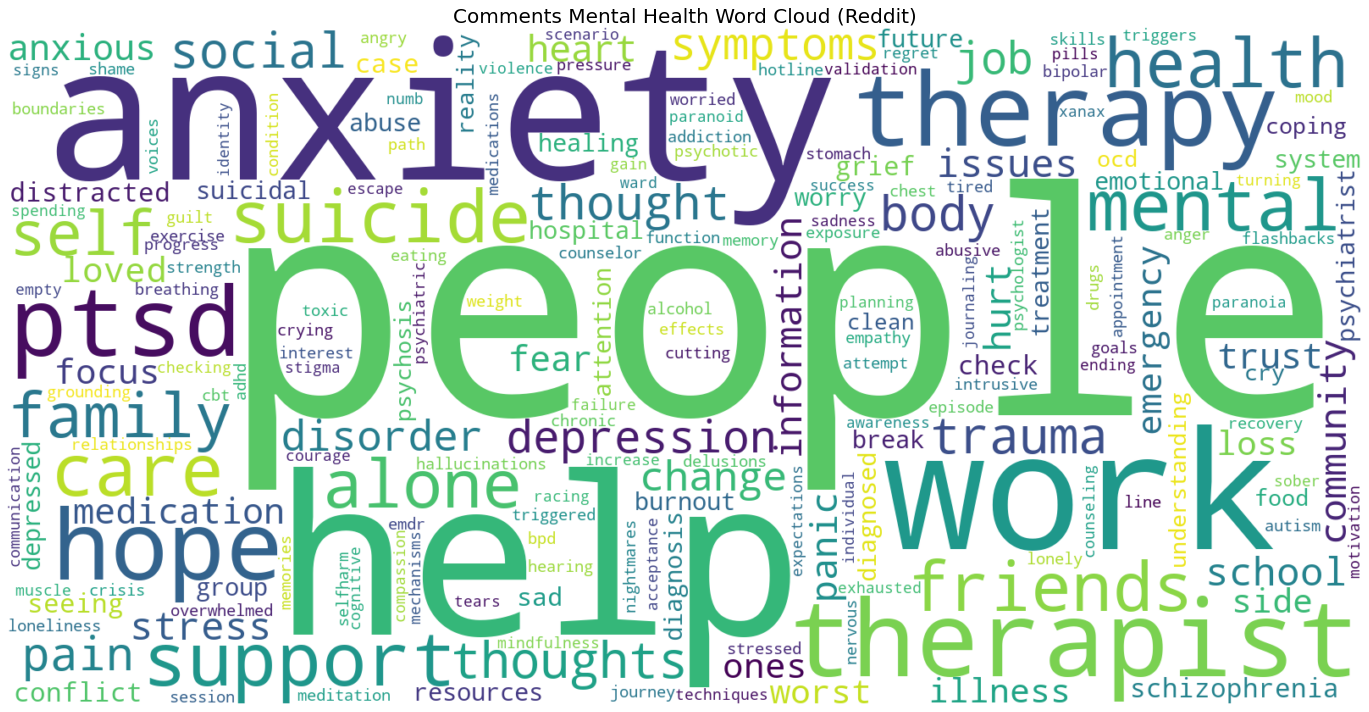

In [2]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import re

# Load data
df = pd.read_csv("reddit_clean_data.csv")
text_data = df['comments'].dropna().astype(str).str.lower().tolist()
joined_text = ' '.join(text_data)

# Clean punctuation
joined_text = re.sub(r'[^a-zA-Z\s]', '', joined_text)

# Extended mental health vocabulary
# Dense Mental Health Vocabulary - Copy this into your code
mental_health_vocab = {
    # Core mental health terms
    'anxiety', 'anxious', 'panic', 'fear', 'worry', 'worried', 'overwhelmed', 'nervous', 'restless',
    'depression', 'depressed', 'sad', 'sadness', 'hopeless', 'hopelessness', 'despair', 'melancholy',
    'stress', 'stressed', 'burnout', 'exhausted', 'tired', 'fatigue', 'drained', 'overwhelmed',
    
    # Emotional states
    'lonely', 'loneliness', 'isolation', 'alone', 'empty', 'numbness', 'numb', 'worthless', 
    'shame', 'guilt', 'regret', 'anger', 'angry', 'frustrated', 'irritated', 'agitated',
    'crying', 'cry', 'tears', 'grief', 'mourning', 'loss', 'heartbroken', 'devastated',
    
    # Sleep and energy
    'insomnia', 'sleepless', 'nightmares', 'sleepy', 'drowsy', 'restless', 'tossing', 'turning',
    'oversleeping', 'hypersomnia', 'zombie', 'sluggish', 'lethargic', 'weary', 'worn',
    
    # Suicidal ideation and self-harm
    'suicidal', 'suicide', 'selfharm', 'cutting', 'hurt', 'pain', 'ending', 'escape', 'disappear',
    'ideation', 'thoughts', 'planning', 'attempt', 'crisis', 'emergency', 'hotline',
    
    # Trauma and PTSD
    'trauma', 'ptsd', 'flashbacks', 'triggers', 'triggered', 'abuse', 'violence', 'assault',
    'memories', 'intrusive', 'avoidance', 'hypervigilant', 'dissociation', 'detachment',
    'survivor', 'recovery', 'healing', 'coping', 'resilience',
    
    # Anxiety disorders
    'phobia', 'agoraphobia', 'claustrophobia', 'social', 'generalized', 'gad', 'panic',
    'palpitations', 'sweating', 'trembling', 'shaking', 'breathless', 'choking',
    'racing', 'catastrophic', 'catastrophizing', 'worst', 'case', 'scenario',
    
    # Depression symptoms
    'anhedonia', 'pleasure', 'interest', 'motivation', 'concentration', 'focus',
    'memory', 'indecisive', 'sluggish', 'psychomotor', 'agitation', 'retardation',
    'appetite', 'weight', 'gain', 'loss', 'eating', 'food',
    
    # Mood disorders
    'bipolar', 'manic', 'mania', 'hypomania', 'episode', 'cycling', 'mood', 'swings',
    'euphoric', 'grandiose', 'impulsive', 'reckless', 'spending', 'hypersexual',
    'dysthymia', 'persistent', 'chronic', 'seasonal', 'affective',
    
    # Personality disorders
    'borderline', 'bpd', 'splitting', 'abandonment', 'unstable', 'identity', 'relationships',
    'narcissistic', 'npd', 'grandiosity', 'empathy', 'antisocial', 'sociopath', 'psychopath',
    'avoidant', 'dependent', 'paranoid', 'schizoid', 'histrionic', 'obsessive', 'compulsive',
    
    # Psychosis and severe mental illness
    'psychosis', 'psychotic', 'hallucinations', 'voices', 'hearing', 'seeing', 'delusions',
    'paranoia', 'paranoid', 'conspiracy', 'persecution', 'reality', 'testing', 'break',
    'schizophrenia', 'schizoaffective', 'catatonia', 'disorganized', 'thought', 'disorder',
    
    # Eating disorders
    'anorexia', 'bulimia', 'binge', 'purge', 'restrict', 'restriction', 'calories',
    'weight', 'body', 'image', 'dysmorphia', 'orthorexia', 'emotional', 'compulsive',
    'laxatives', 'vomiting', 'exercise', 'excessive', 'mirror', 'checking',
    
    # OCD and related disorders
    'ocd', 'obsessions', 'compulsions', 'intrusive', 'unwanted', 'repetitive', 'rituals',
    'checking', 'washing', 'counting', 'ordering', 'symmetry', 'contamination',
    'hoarding', 'trichotillomania', 'dermatillomania', 'picking', 'pulling',
    
    # Addiction and substance use
    'addiction', 'substance', 'alcohol', 'drugs', 'withdrawal', 'detox', 'rehab',
    'relapse', 'recovery', 'sobriety', 'clean', 'sober', 'cravings', 'triggers',
    'enabling', 'codependent', 'rock', 'bottom', 'intervention', 'aa', 'na',
    
    # ADHD and neurodevelopmental
    'adhd', 'attention', 'hyperactive', 'impulsive', 'focus', 'concentration', 'distracted',
    'procrastination', 'executive', 'function', 'autism', 'aspergers', 'sensory',
    'stimming', 'meltdown', 'shutdown', 'masking', 'social', 'communication',
    
    # Treatment and therapy
    'therapy', 'therapist', 'counseling', 'counselor', 'psychologist', 'psychiatrist',
    'psychotherapy', 'cbt', 'dbt', 'emdr', 'exposure', 'mindfulness', 'meditation',
    'session', 'appointment', 'treatment', 'intervention', 'support', 'group',
    'individual', 'family', 'couples', 'behavioral', 'cognitive', 'dialectical',
    
    # Medications
    'medication', 'medications', 'pills', 'prescription', 'antidepressant', 'ssri', 'snri',
    'antipsychotic', 'mood', 'stabilizer', 'lithium', 'benzodiazepine', 'xanax', 'ativan',
    'prozac', 'zoloft', 'lexapro', 'wellbutrin', 'abilify', 'seroquel', 'lamictal',
    'side', 'effects', 'withdrawal', 'titration', 'dosage', 'increase', 'decrease',
    
    # Crisis and hospitalization
    'crisis', 'emergency', 'hospital', 'psychiatric', 'ward', 'inpatient', 'outpatient',
    'admission', 'discharge', 'evaluation', 'assessment', 'screening', 'triage',
    '911', 'hotline', 'crisis', 'line', 'intervention', 'welfare', 'check',
    
    # Coping and support
    'coping', 'strategies', 'mechanisms', 'skills', 'techniques', 'grounding', 'breathing',
    'relaxation', 'progressive', 'muscle', 'visualization', 'journaling', 'exercise',
    'support', 'system', 'friends', 'family', 'loved', 'ones', 'community', 'peer',
    'understanding', 'empathy', 'compassion', 'validation', 'acceptance', 'hope',
    
    # Mental health awareness
    'mental', 'health', 'illness', 'disorder', 'condition', 'diagnosis', 'diagnosed',
    'symptoms', 'signs', 'awareness', 'stigma', 'discrimination', 'understanding',
    'education', 'advocacy', 'campaign', 'resources', 'information', 'help',
    
    # Physical symptoms
    'headaches', 'migraines', 'tension', 'muscle', 'aches', 'pain', 'chronic',
    'fatigue', 'exhaustion', 'nausea', 'stomach', 'digestive', 'issues',
    'heart', 'racing', 'chest', 'tight', 'dizzy', 'lightheaded', 'faint',
    
    # Social aspects
    'relationships', 'social', 'isolation', 'withdrawal', 'avoidance', 'rejection',
    'abandonment', 'trust', 'issues', 'intimacy', 'boundaries', 'communication',
    'conflict', 'people', 'pleasing', 'codependency', 'toxic', 'abusive',
    
    # Work and school
    'work', 'job', 'school', 'academic', 'performance', 'productivity', 'burnout',
    'stress', 'deadline', 'pressure', 'expectations', 'perfectionism', 'failure',
    'success', 'achievement', 'goals', 'motivation', 'procrastination',
    
    # Recovery and wellness
    'recovery', 'healing', 'wellness', 'self', 'care', 'improvement', 'progress',
    'setback', 'journey', 'path', 'growth', 'change', 'transformation',
    'resilience', 'strength', 'courage', 'hope', 'optimism', 'future'
}

# Tokenize and filter
tokens = joined_text.split()
filtered_tokens = [word for word in tokens if word in mental_health_vocab]

# Generate word frequency
word_freq = Counter(filtered_tokens)

# Word cloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', min_font_size=8).generate_from_frequencies(word_freq)

# Plot
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Comments Mental Health Word Cloud (Reddit)", fontsize=20)
plt.tight_layout()
plt.show()


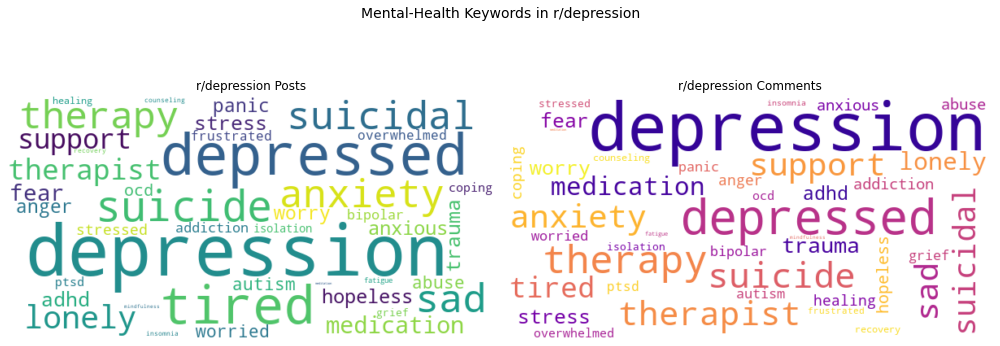

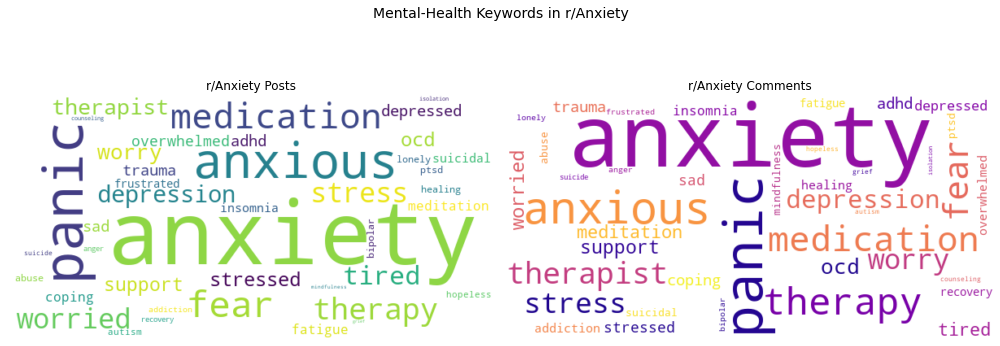

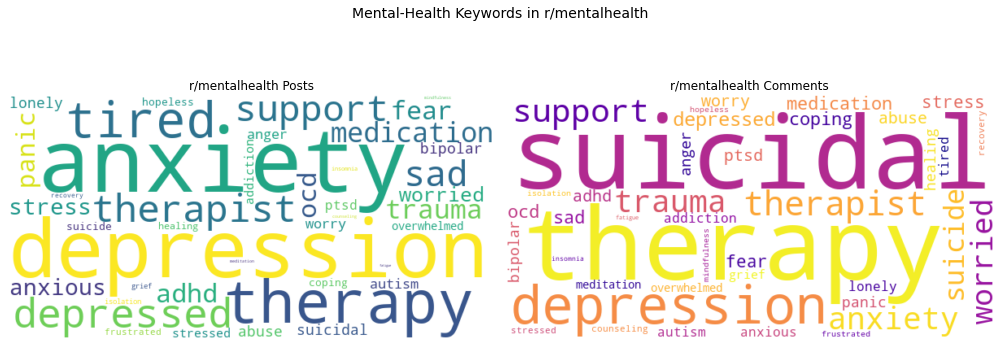

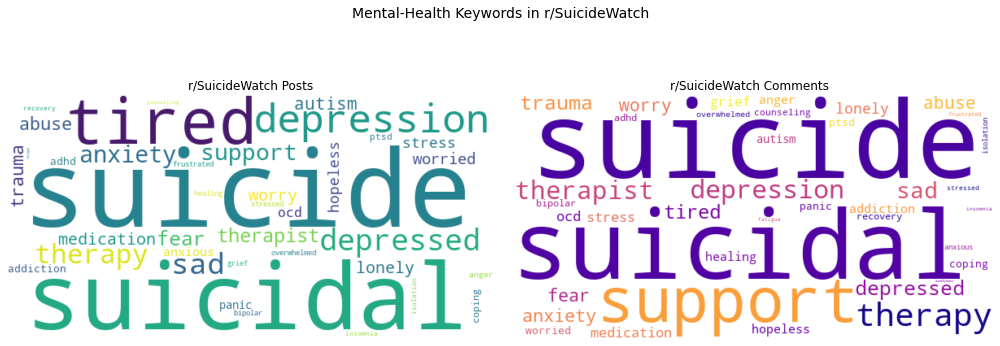

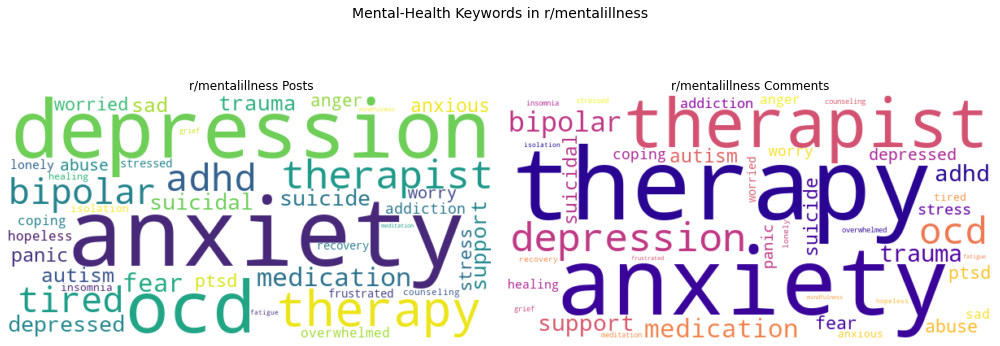

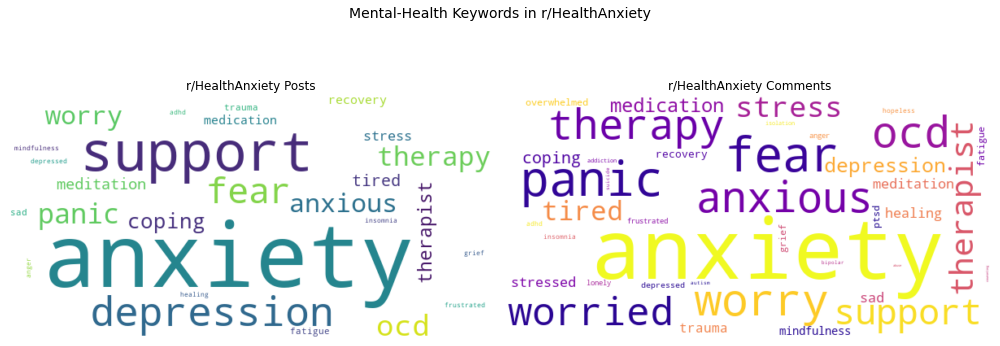

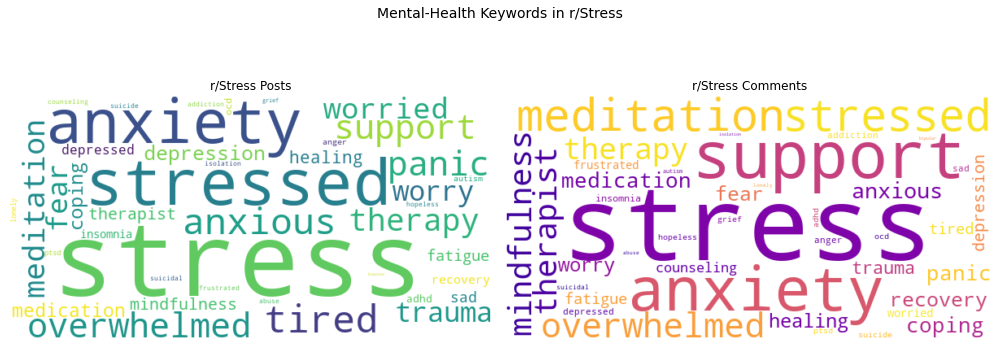

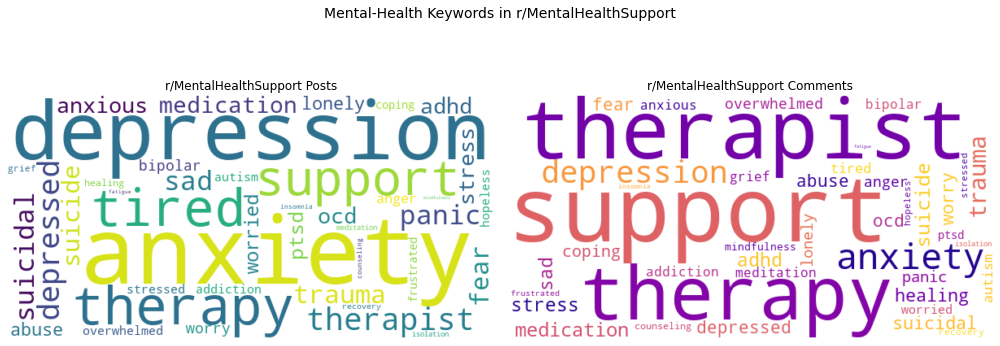

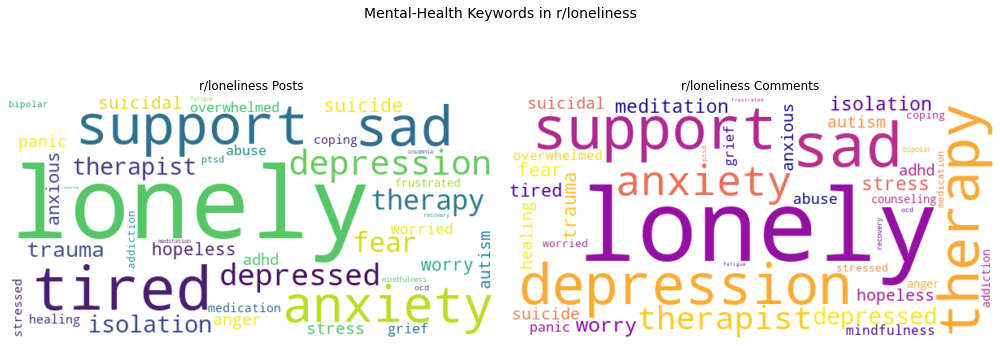

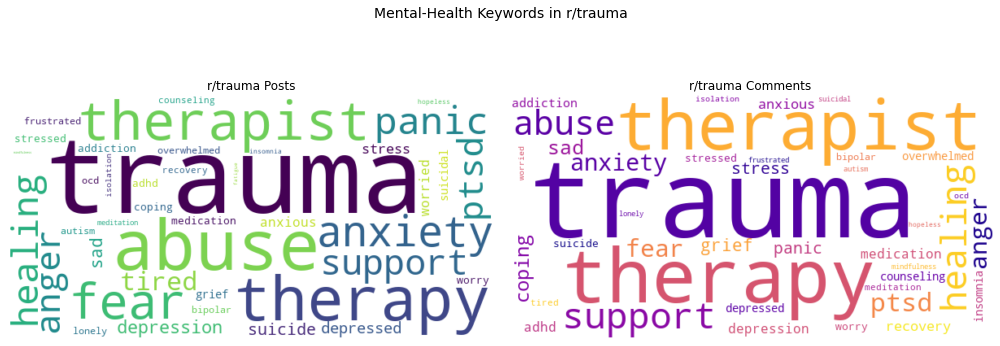

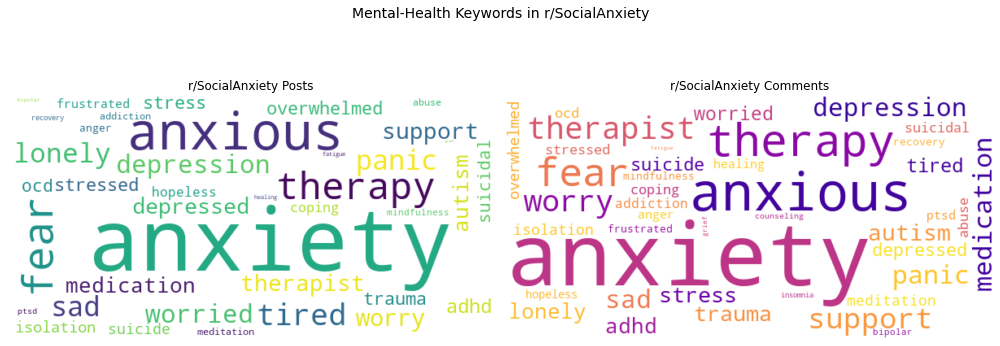

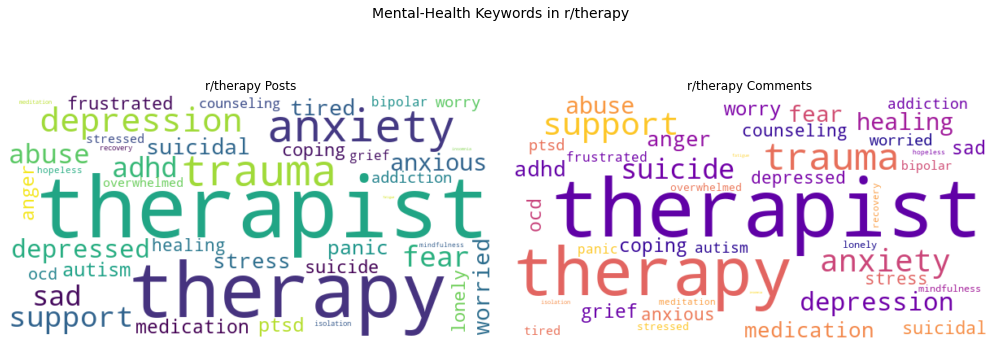

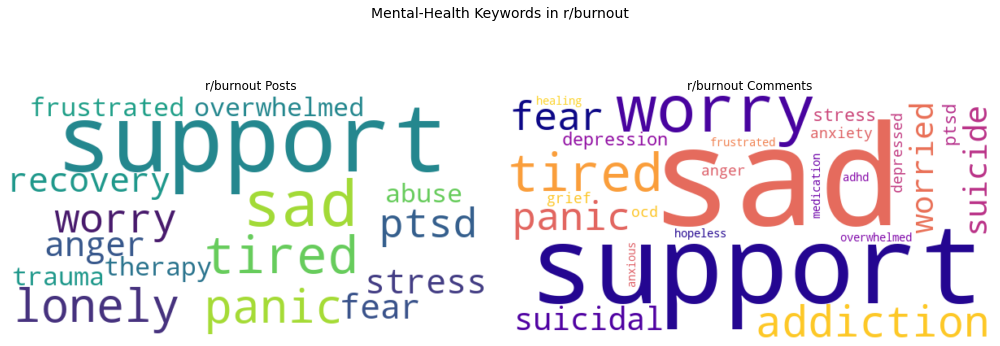

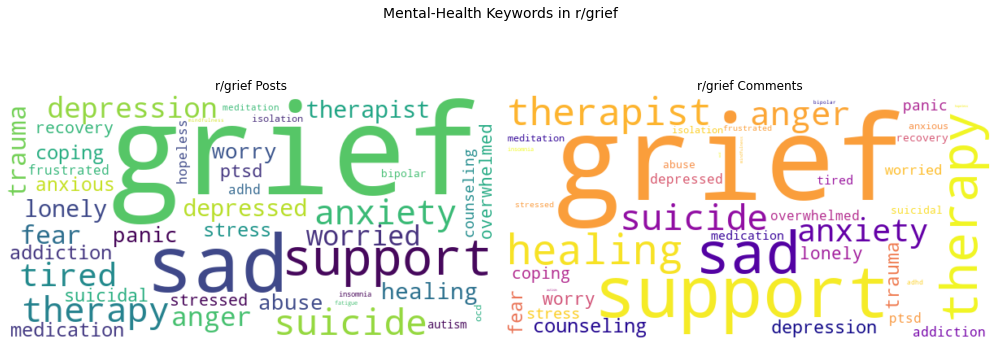

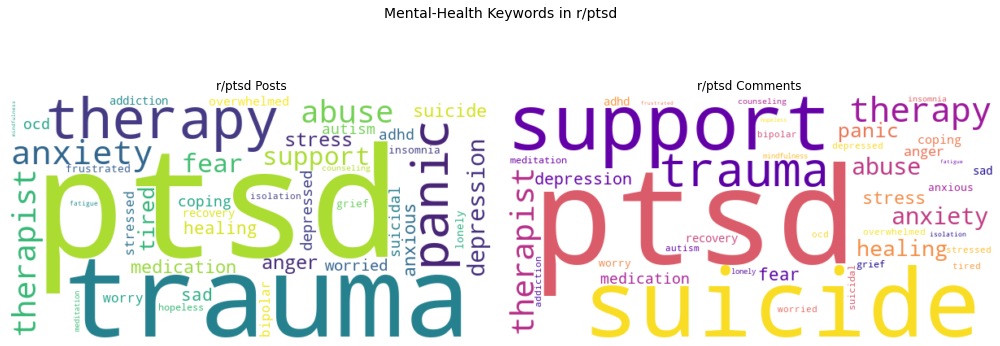

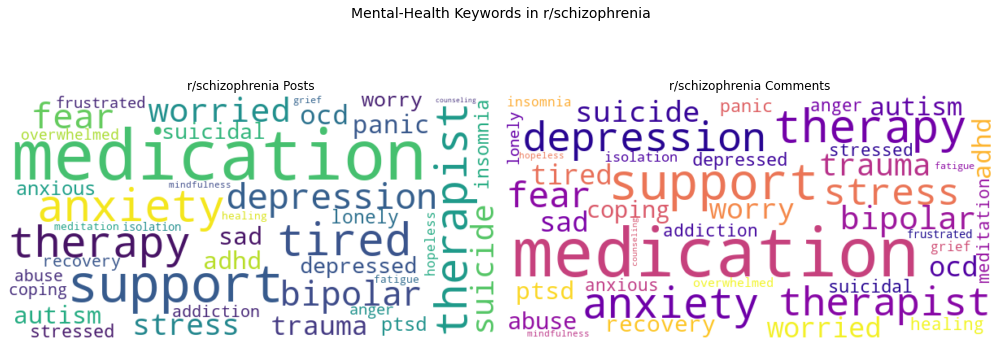

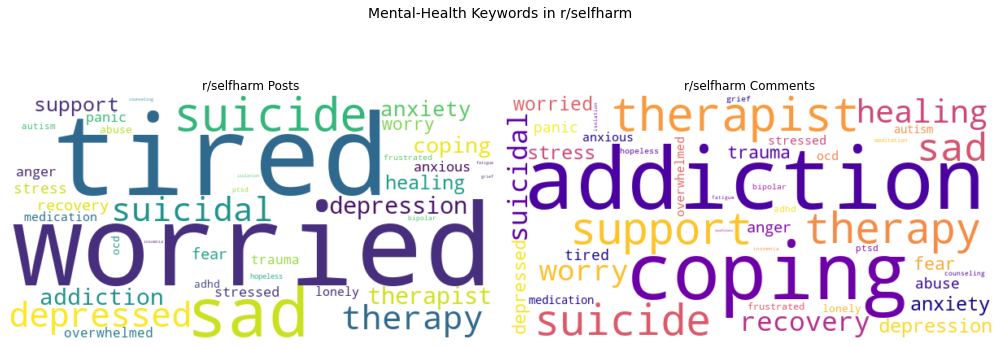

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# ─── CONFIG ────────────────────────────────────────────────────────────────
INPUT_CSV = "reddit_clean_data.csv"  
MAX_WORDS = 50                       # max terms per cloud
# ────────────────────────────────────────────────────────────────────────────

# 1) Mental‑health keywords
MH_KEYWORDS = {
    'anxiety','anxious','depression','depressed','stress','stressed','worry','worried',
    'fear','panic','overwhelmed','sad','lonely','hopeless','grief','anger','frustrated',
    'ptsd','trauma','bipolar','ocd','adhd','autism','suicidal','suicide','addiction','abuse',
    'therapy','therapist','counseling','medication','support','healing','recovery','coping',
    'mindfulness','meditation','isolation','insomnia','tired','fatigue'
}

# 2) Build a robust stop‑list
STOP = set(ENGLISH_STOP_WORDS) | {
    'im','ive','cant','dont','wont','isnt','theyre','youre','just','really','like','know',
    'think','feel','got','also'
}

# 3) Tokenize & filter helper
def tokenize_filter(series):
    tokens = []
    for txt in series.dropna().astype(str):
        clean = re.sub(r'[^a-zA-Z\s]', ' ', txt.lower())
        for w in clean.split():
            if w not in STOP and w in MH_KEYWORDS:
                tokens.append(w)
    return tokens

# 4) Word‑cloud factory
def make_cloud(freqs, cmap):
    return WordCloud(
        width=600, height=300,
        background_color='white',
        colormap=cmap,
        max_words=MAX_WORDS
    ).generate_from_frequencies(freqs)

# 5) Load data
df = pd.read_csv(INPUT_CSV)

# 6) Iterate each subreddit and display clouds
for sub in df['subreddit'].dropna().unique():
    subdf = df[df['subreddit'] == sub]
    
    # a) posts tokens from clean_text
    post_toks = tokenize_filter(subdf['clean_text'])
    post_freq = Counter(post_toks)
    
    # b) comment tokens
    com_toks  = tokenize_filter(subdf['comments'])
    com_freq  = Counter(com_toks)
    
    # 7) Plot inline
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    if post_freq:
        ax1.imshow(make_cloud(post_freq, 'viridis'), interpolation='bilinear')
    else:
        ax1.text(0.5, 0.5, 'No MH words in posts', ha='center', va='center')
    ax1.set_title(f"r/{sub} Posts", fontsize=12)
    ax1.axis('off')
    
    if com_freq:
        ax2.imshow(make_cloud(com_freq, 'plasma'), interpolation='bilinear')
    else:
        ax2.text(0.5, 0.5, 'No MH words in comments', ha='center', va='center')
    ax2.set_title(f"r/{sub} Comments", fontsize=12)
    ax2.axis('off')
    
    plt.suptitle(f"Mental‑Health Keywords in r/{sub}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()


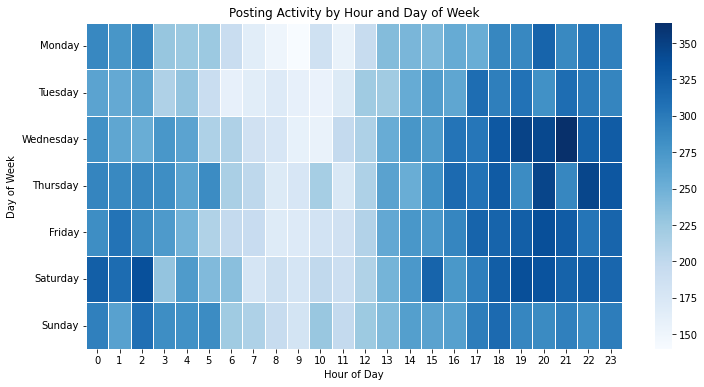

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df['hour'] = df['created_utc'].dt.hour
df['weekday'] = df['created_utc'].dt.day_name()

pivot = df.groupby(['weekday', 'hour']).size().unstack(fill_value=0)
pivot = pivot.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='Blues', linewidths=0.5)
plt.title("Posting Activity by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()



In [6]:
clean_df

id             created   subreddit  \
0      1lyn5k5 2025-07-13 07:45:14  depression   
1      1lyn4uo 2025-07-13 07:43:55  depression   
2      1lyn476 2025-07-13 07:42:44  depression   
3      1lymwrv 2025-07-13 07:29:13  depression   
4      1lymw0o 2025-07-13 07:27:48  depression   
...        ...                 ...         ...   
44197  1k25ob4 2025-04-18 14:01:53    selfharm   
44198  1jjayvc 2025-03-25 04:08:56    selfharm   
44199  1j43tce 2025-03-05 14:05:17    selfharm   
44200  1j3zidt 2025-03-05 09:45:25    selfharm   
44201  1j1logs 2025-03-02 07:45:12    selfharm   

                                                  tokens  
0      [I, get, really, depressed, drink, much, alcoh...  
1      [I, smart, I, chronic, depression, dpdr, one, ...  
2      [laziness, I, know, stuff, like, brush, tooth,...  
3      [I, stressed, tired, exist, first, I, suicidal...  
4      [I, think, I, might, depress, I, feel, like, l...  
...                                                  ...  
44197  [selfish, walk, uncovered, wound, scar, I, fee...  
44198  [guy, cut, every, anemia, I, period, day, I, g...  
44199  [normal, I, cut, I, start, laugh, cry, shake, ...  
44200  [bro, I, need, bad, I, want, razor, blade, I, ...  
44201  [tell, parent, I, read, horror, story, sub, pu...  

[44202 rows x 4 columns]

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])


=== TEXT LENGTH STATISTICS ===
Clean Text Statistics:
        text_length    word_count
count  43122.000000  43122.000000
mean     924.357776    183.549256
std     1206.251596    239.019581
min        1.000000      1.000000
25%      273.000000     54.000000
50%      597.000000    119.000000
75%     1143.000000    228.000000
max    33608.000000   6661.000000

Title Statistics:
       title_length  title_word_count
count  43122.000000      43122.000000
mean      44.202889          8.220236
std       32.025334          5.982205
min        1.000000          1.000000
25%       23.000000          4.000000
50%       37.000000          7.000000
75%       56.000000         10.000000
max      300.000000         72.000000


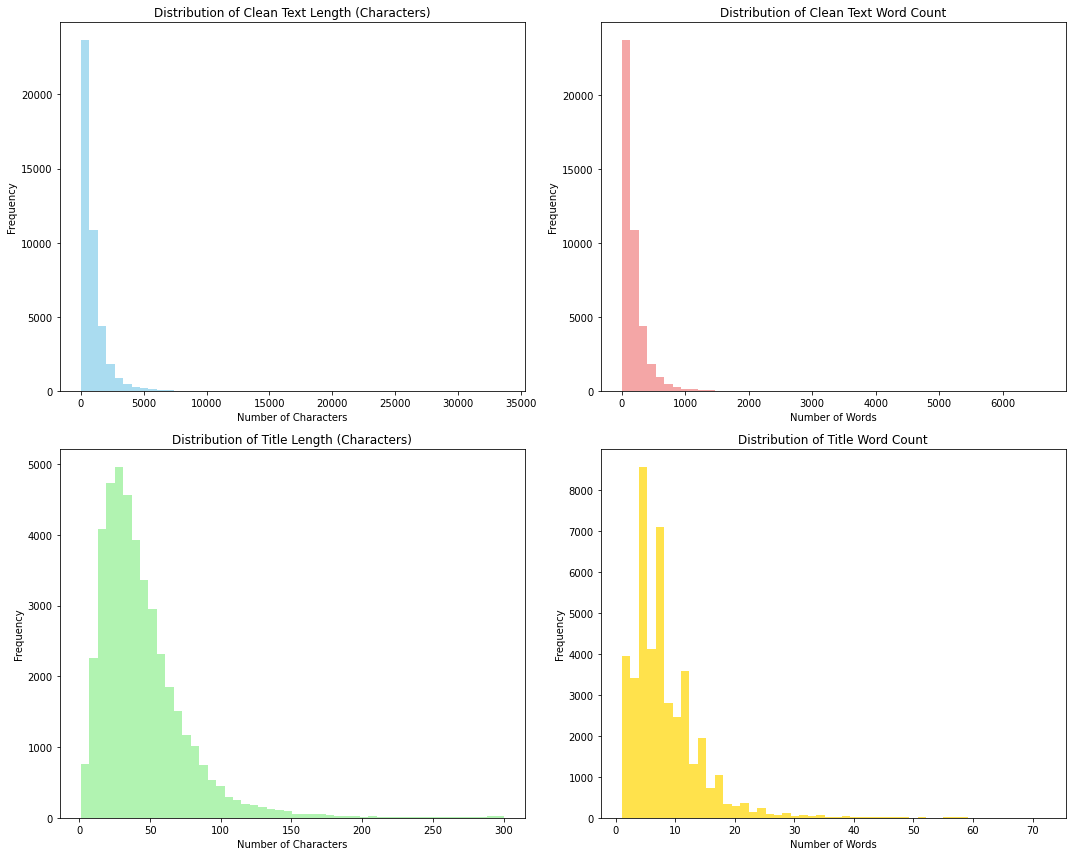

In [ ]:
# Analyse text lengths
df['text_length'] = df['clean_text'].str.len()
df['word_count'] = df['clean_text'].str.split().str.len()

# Also analyse title lengths
df['title_length'] = df['title'].fillna('').str.len()
df['title_word_count'] = df['title'].fillna('').str.split().str.len()

print("=== TEXT LENGTH STATISTICS ===")
print("Clean Text Statistics:")
print(df[['text_length', 'word_count']].describe())
print("\nTitle Statistics:")
print(df[['title_length', 'title_word_count']].describe())

# Plot text length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Clean text character length
axes[0,0].hist(df['text_length'], bins=50, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribution of Clean Text Length (Characters)')
axes[0,0].set_xlabel('Number of Characters')
axes[0,0].set_ylabel('Frequency')

# Clean text word count
axes[0,1].hist(df['word_count'], bins=50, alpha=0.7, color='lightcoral')
axes[0,1].set_title('Distribution of Clean Text Word Count')
axes[0,1].set_xlabel('Number of Words')
axes[0,1].set_ylabel('Frequency')

# Title length
axes[1,0].hist(df['title_length'], bins=50, alpha=0.7, color='lightgreen')
axes[1,0].set_title('Distribution of Title Length (Characters)')
axes[1,0].set_xlabel('Number of Characters')
axes[1,0].set_ylabel('Frequency')

# Title word count
axes[1,1].hist(df['title_word_count'], bins=50, alpha=0.7, color='gold')
axes[1,1].set_title('Distribution of Title Word Count')
axes[1,1].set_xlabel('Number of Words')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

=== SUBREDDIT ANALYSIS ===
Subreddit distribution:
schizophrenia          3213
mentalhealth           3186
selfharm               3147
Anxiety                3141
ptsd                   3089
therapy                3088
depression             2982
SocialAnxiety          2949
mentalillness          2876
MentalHealthSupport    2797
SuicideWatch           2519
burnout                2374
grief                  2310
loneliness             2247
Stress                 1668
Name: subreddit, dtype: int64


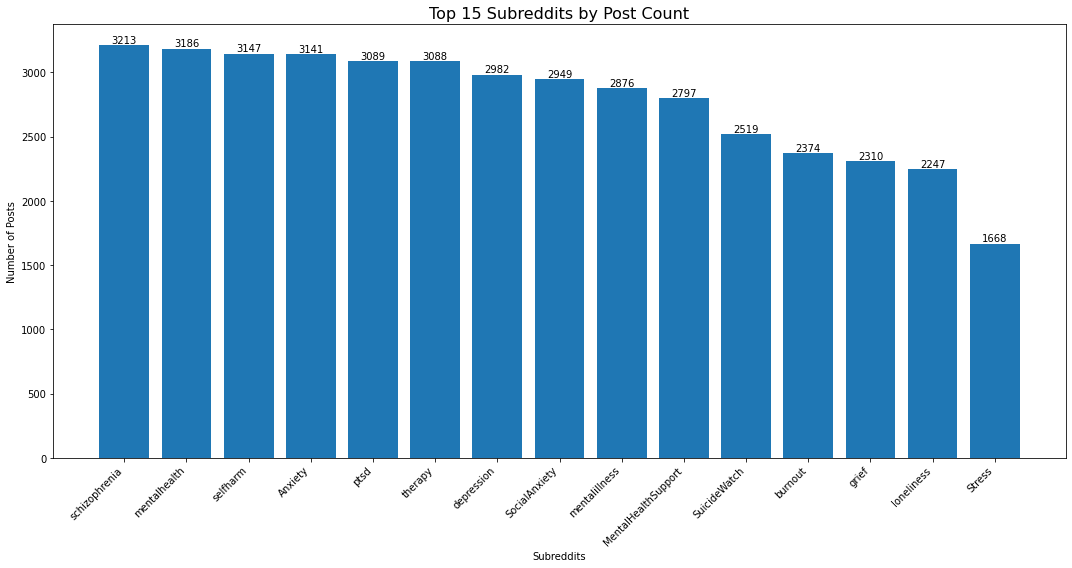


Total unique subreddits: 17
Most active subreddit: schizophrenia (3213 posts)


In [ ]:
# Analyse subreddit distribution
print("=== SUBREDDIT ANALYSIS ===")
subreddit_counts = df['subreddit'].value_counts()
print("Subreddit distribution:")
print(subreddit_counts.head(15))

# Plot subreddit distribution (top 15)
plt.figure(figsize=(15, 8))
top_subreddits = subreddit_counts.head(15)
bars = plt.bar(range(len(top_subreddits)), top_subreddits.values)
plt.title('Top 15 Subreddits by Post Count', fontsize=16)
plt.xlabel('Subreddits')
plt.ylabel('Number of Posts')
plt.xticks(range(len(top_subreddits)), top_subreddits.index, rotation=45, ha='right')

# Add count labels on bars
for bar, count in zip(bars, top_subreddits.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nTotal unique subreddits: {df['subreddit'].nunique()}")
print(f"Most active subreddit: {subreddit_counts.index[0]} ({subreddit_counts.iloc[0]} posts)")

=== TEMPORAL ANALYSIS ===
Date range: 2024-01-01 00:19:44 to 2025-07-13 18:00:09


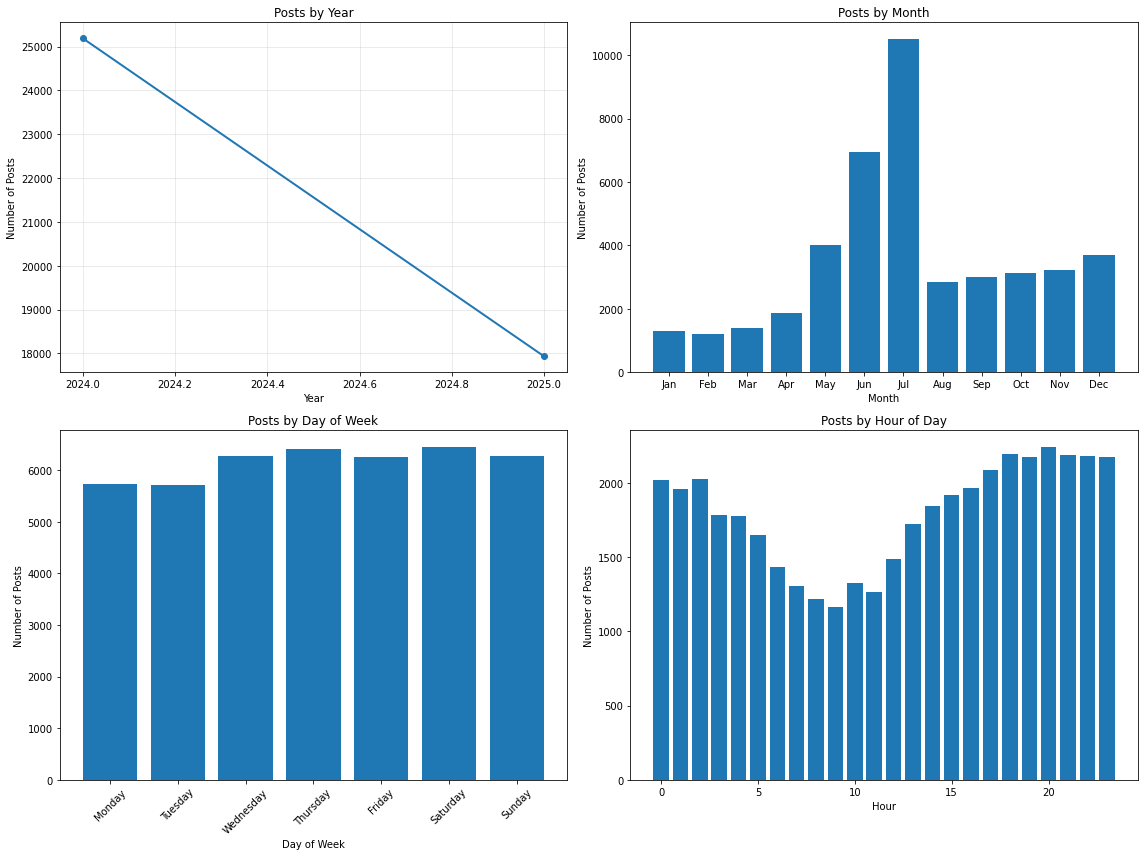

In [22]:
# Temporal analysis
print("=== TEMPORAL ANALYSIS ===")

# Convert to datetime if not already
df['created_utc'] = pd.to_datetime(df['created_utc'], errors='coerce')
df['year'] = df['created_utc'].dt.year
df['month'] = df['created_utc'].dt.month
df['day_of_week'] = df['created_utc'].dt.day_name()
df['hour'] = df['created_utc'].dt.hour
df['date'] = df['created_utc'].dt.date

# Remove rows with invalid dates
df_temporal = df.dropna(subset=['created_utc'])

print(f"Date range: {df_temporal['created_utc'].min()} to {df_temporal['created_utc'].max()}")

# Plot temporal trends
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Posts by year
yearly_counts = df_temporal['year'].value_counts().sort_index()
axes[0,0].plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2)
axes[0,0].set_title('Posts by Year')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Number of Posts')
axes[0,0].grid(True, alpha=0.3)

# Posts by month
monthly_counts = df_temporal['month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0,1].bar(monthly_counts.index, monthly_counts.values)
axes[0,1].set_title('Posts by Month')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Number of Posts')
axes[0,1].set_xticks(range(1, 13))
axes[0,1].set_xticklabels(month_names)

# Posts by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df_temporal['day_of_week'].value_counts().reindex(day_order)
axes[1,0].bar(range(len(day_counts)), day_counts.values)
axes[1,0].set_title('Posts by Day of Week')
axes[1,0].set_xlabel('Day of Week')
axes[1,0].set_ylabel('Number of Posts')
axes[1,0].set_xticks(range(len(day_counts)))
axes[1,0].set_xticklabels(day_counts.index, rotation=45)

# Posts by hour
hourly_counts = df_temporal['hour'].value_counts().sort_index()
axes[1,1].bar(hourly_counts.index, hourly_counts.values)
axes[1,1].set_title('Posts by Hour of Day')
axes[1,1].set_xlabel('Hour')
axes[1,1].set_ylabel('Number of Posts')

plt.tight_layout()
plt.show()